Feature Selection of Criticality Score Algorithm Data \\
Author: Blaise Swartwood

In [19]:
#importing required packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import KFold
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [20]:
#accessing data file
df = pd.read_csv('CSDataAsCSV.csv', usecols=[i for i in range(6, 18) if i != 16])
df.head()

,created_since,updated_since,contributor_count,org_count,commit_frequency,recent_release_count,updated_issues_count,closed_issues_count,issue_comment_frequency,github_mention_count,criticality_score
0,131,0,5000,10,1555.33,69,552,266,3.18,57193965,0.92520
1,209,0,2044,5,70.83,49,896,806,13.15,36120246,0.89559
2,162,0,3472,9,48.37,67,36122,34479,2.00,1168604,0.88907
3,97,0,4367,5,138.08,65,86352,84020,2.00,529999,0.88400
4,151,0,3579,13,104.13,69,27449,26723,2.00,88134,0.87876


In [21]:
#scaling the data
scaler = StandardScaler()
scaled_df=df.copy()
scaled_df=pd.DataFrame(scaler.fit_transform(scaled_df), columns=scaled_df.columns)
scaled_df.head()

,created_since,updated_since,contributor_count,org_count,commit_frequency,recent_release_count,updated_issues_count,closed_issues_count,issue_comment_frequency,github_mention_count,criticality_score
0,1.569323,-0.552789,38.878494,3.925732,92.450841,1.681014,0.600905,0.262709,1.326020,725.868715,6.288175
1,3.512865,-0.552789,15.831261,1.566135,4.164546,1.178037,1.042876,0.999320,7.838074,458.413532,5.992633
2,2.341756,-0.552789,26.965039,3.453812,2.828804,1.630716,46.301216,46.932421,0.555285,14.827953,5.927555
3,0.722138,-0.552789,33.943142,1.566135,8.164043,1.580418,110.836684,114.510949,0.555285,6.723156,5.876951
4,2.067667,-0.552789,27.799293,5.341490,6.144966,1.681014,35.158151,36.352516,0.555285,1.115267,5.824650


In [22]:
#separating features and criticality score
X = scaled_df.drop('criticality_score', axis=1)
y = scaled_df['criticality_score']

In [23]:
#splitting training vs test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=101)









1) SELECT FROM MODEL









In [24]:
#building and training the model
estimator = Lasso(alpha = 0.1)
featureSelection = SelectFromModel(estimator)
featureSelection.fit(X, y)

SelectFromModel(estimator=Lasso(alpha=0.1))

In [25]:
#obtaining the selected features
selectedFeatures = featureSelection.transform(X)
X.columns[featureSelection.get_support()]

Index(['updated_since', 'org_count', 'updated_issues_count',
       'issue_comment_frequency'],
      dtype='object')








2) RECURSIVE FEATURE SELECTION








In [26]:
#building and training the model
model = ElasticNet(alpha = 0.01)
rfe = RFE(model)
rfe.fit(X_train, y_train)

RFE(estimator=ElasticNet(alpha=0.01))

In [27]:
print('The selected features are: ', rfe.support_)
print('The relative ranking of features is: ', rfe.ranking_)
print('The test score of the data is: ', rfe.score(X_test, y_test))

The selected features are:  [ True  True False  True False False  True False  True False]
The relative ranking of features is:  [1 1 3 1 4 2 1 6 1 5]
The test score of the data is:  0.7104279892338332


In [28]:
#display important features nicely
pd.DataFrame(rfe.support_,index=X.columns,columns=["Necessary Feature"])

,Necessary Feature
created_since,True
updated_since,True
contributor_count,False
org_count,True
commit_frequency,False
recent_release_count,False
updated_issues_count,True
closed_issues_count,False
issue_comment_frequency,True
github_mention_count,False


In [29]:
#Display relative importance of features nicely
pd.DataFrame(rfe.ranking_,index=X.columns,columns=["Relative Importance Ranking"])

,Relative Importance Ranking
created_since,1
updated_since,1
contributor_count,3
org_count,1
commit_frequency,4
recent_release_count,2
updated_issues_count,1
closed_issues_count,6
issue_comment_frequency,1
github_mention_count,5











3) Sequential Forward Floating Selection










In [30]:
#building and training the model
en = ElasticNet(alpha = 0.1)

sfs = SFS(en, 
          k_features=5, 
          forward=True, 
          floating=True, 
          scoring='r2',
          cv = KFold(n_splits=5, shuffle=True))

sfs = sfs.fit(X, y)

In [31]:
#printing important features
print('\nSequential Forward Floating Selection (k=5):')
print(sfs.k_feature_idx_)
print('CV Score:')
print(sfs.k_score_)


Sequential Forward Floating Selection (k=5):
(1, 2, 3, 6, 8)
CV Score:
0.7085979633164465


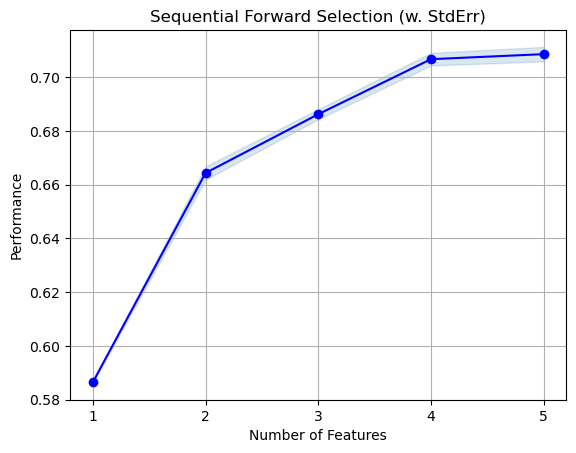

In [32]:
#plotting performance against number of features
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

 
 
 
 
 
 
 
 
 
 
 4) Sequential Backward Floating Selection:
 
 
 
 
 
 
 
 
 

In [33]:
#building and training the model
en = ElasticNet(alpha=0.1)

sfs2 = SFS(en, 
          k_features=5, 
          forward=False, 
          floating=True, 
          scoring='r2',
          cv = KFold(n_splits=5, shuffle=True))

sfs2 = sfs2.fit(X, y)

In [34]:
#printing important features
print('\nSequential Backward Floating Selection (k=5):')
print(sfs2.k_feature_idx_)
print('CV Score:')
print(sfs2.k_score_)


Sequential Backward Floating Selection (k=5):
(1, 2, 3, 6, 8)
CV Score:
0.7087519400188521
